#Efficient Data stream anomaly detection

This python notebook serves as a step by step project that explains how to simulate a real time data stream with seasonal trends and anomalies, which is then used to train a model that can detect such anomalies. The model is efficient and robust, that can handle both seasonal trends and concept drifts.

## Requirements


The requirements for this project are the following libraries :

- numpy (for simulating a data stream)
- pandas (for representing data in data frames)
- random (for introducing randomised anomalies)
- datetime (to handle timestamps in real time data streams)
- matplotlib.pyplot (to visualise data)
- matplotlib.dates (to visualise dates)

Note : this is an optional library to showcase the STL approach using a library, to show a comparison to the manual approach attempted. comment out section 4 code if you want to skip this.

- statsmodels.tsa.seasonal STL (STL model from statsmodels)

In [ ]:
# Importing all requirements for the project
import numpy as np
import pandas as pd
import random
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## 1. Data Stream Emulation

The first step is to emulate a data stream that can be used for anomaly detection. This project is a case study of the volume of natural gas sold each day in the year 2021, 2022 and 2023 respectively.

The parameters that produce the random data that will be used for sales records and anomaly introduction is set. This involves setting the total number of transactions that are carried in a year, the seed for randomisation and also the seasonal factors which must be accounted for.

Next, a function `generate_synthetic_gas_sales_data` is defined to generate the data with the parameters defined previously. The sales data is generated from Jan 1 to Dec 31 for each year.

numpy is used to generate a base data using normal distribution, which is then adjusted for `seasonal_factors` in each month. Anomalies are randomly introduced to the data stream to simulate time series data of natural gas sold in therms. The anomalies are capped at a 5% value to reflect reality.

The following code block produces the three data frames that will be used for analysis and anomaly detection, named `df_2021, df_2022 (analysis)` and `df_2023 (anomaly detection)` respectively.

In [ ]:
np.random.seed(42) # set random seed for reproducing results.
num_sales_per_year = 1000  # Total number of sales per year.

# Seasonal adjustment factors.
seasonal_factors = {
    1: 0.8,   # January
    2: 0.9,   # February
    3: 1.0,   # March
    4: 1.0,   # April
    5: 1.1,   # May
    6: 1.1,   # June
    7: 1.2,   # July
    8: 1.2,   # August
    9: 1.0,   # September
    10: 1.3,  # October
    11: 1.5,  # November
    12: 1.5   # December
}

# Function to generate synthetic gas sales data for a given year
def generate_synthetic_gas_sales_data(year, num_sales):
    start_date = datetime(year, 1, 1)  # Start date of the year
    end_date = datetime(year, 12, 31)  # End date of the year

    # Generate dates for sales
    date_range = pd.date_range(start=start_date, end=end_date, freq='H')
    sales_dates = np.random.choice(date_range, num_sales)

    # Generate base normal gas sales amounts
    base_normal_sales = np.random.normal(loc=1000, scale=200, size=num_sales)

    # Adjust normal sales for seasonal changes
    adjusted_sales = []
    for i, date in enumerate(sales_dates):
        month = pd.Timestamp(date).month
        seasonal_adjustment = seasonal_factors[month]
        adjusted_amount = base_normal_sales[i] * seasonal_adjustment  # Use indexing
        adjusted_sales.append(adjusted_amount)

    # Introduce anomalies
    anomaly_count = int(num_sales * 0.05)  # 5% anomalies
    anomaly_indices = random.sample(range(num_sales), anomaly_count)

    # Add anomalies (e.g., large sales)
    for idx in anomaly_indices:
        adjusted_sales[idx] *= random.choice([5, 10])  # Increase sales significantly

    # Create DataFrame for natural gas sales
    gas_sales_data = pd.DataFrame({
        'sale_date': sales_dates,
        'volume_therms': adjusted_sales
    })

    # Sort by date and reset index
    gas_sales_data.sort_values(by='sale_date', inplace=True)
    gas_sales_data.reset_index(drop=True, inplace=True)

    return gas_sales_data

# Generate synthetic data for 2021, 2022, and 2023
df_2021 = generate_synthetic_gas_sales_data(2021, num_sales_per_year)
df_2022 = generate_synthetic_gas_sales_data(2022, num_sales_per_year)
df_2023 = generate_synthetic_gas_sales_data(2023, num_sales_per_year)

## 2. Visualise emulated data stream

The data frames generated from the data stream is then plotted on a graph to notice the seasonal trends. Visualising the data helps us to understand the kind of data we are dealing with, and the analysis model that can be used to fit the data stream to predict future sales effectively so that anomalies can be detected easily.

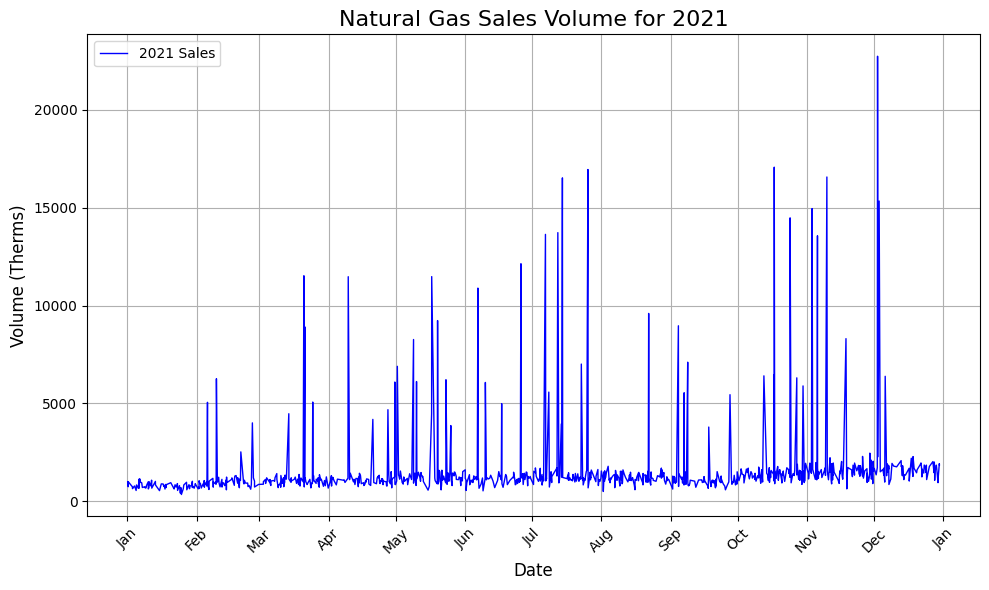

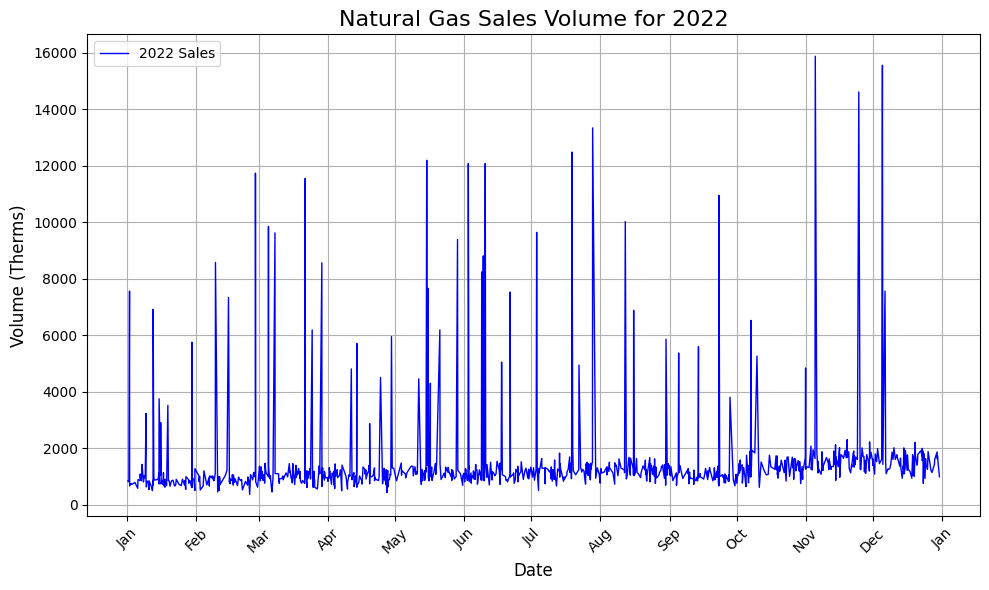

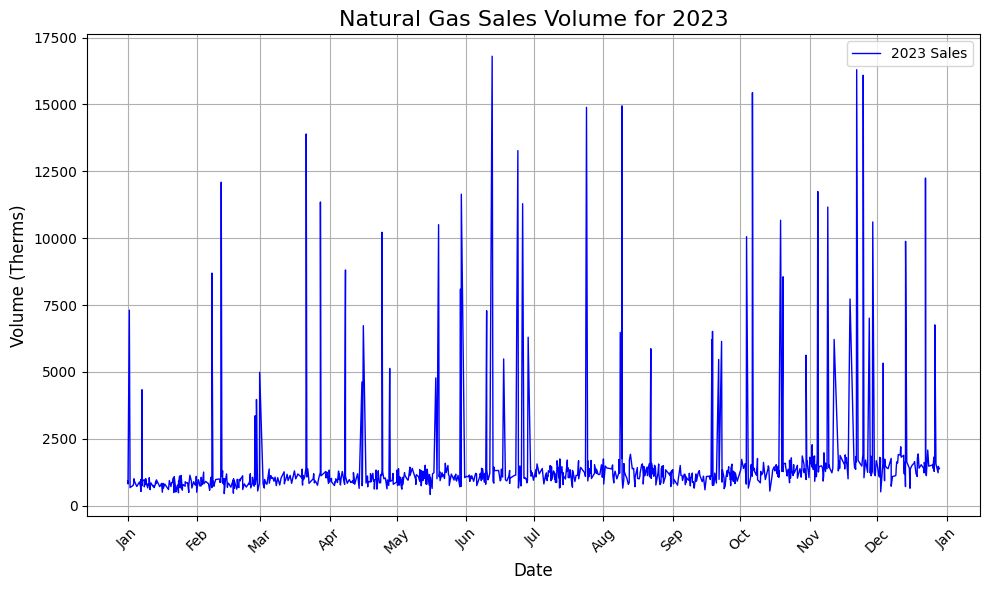

In [ ]:
def plot_gas_sales(df, year):
    plt.figure(figsize=(10, 6))
    plt.plot(df['sale_date'], df['volume_therms'], label=f'{year} Sales', color='blue', linewidth=1)

    # Formatting the plot
    plt.title(f'Natural Gas Sales Volume for {year}', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Volume (Therms)', fontsize=12)
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Format X-axis to show months
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set major ticks to be each month
    plt.xticks(rotation=45)
    plt.tight_layout()  # Adjust layout to avoid label cut-off
    plt.legend()
    plt.show()

# Plotting data for 2021, 2022, and 2023
plot_gas_sales(df_2021, 2021)
plot_gas_sales(df_2022, 2022)
plot_gas_sales(df_2023, 2023)

## 3. Anomaly detection using STL (manual)

- STL decomposition, or **Seasonal-Trend decomposition using Loess** is a robust and flexible method used to decompose a time series into three components, mainly called **the Trend, Seasonality and Residue.**

- The **trend captures the overall movement of the data**, like the upward or downward trajectory of the data over time. Meanwhile, **seasonality of the data captures the repeating patterns that can be observed over a fixed period of time.** The final **residue that is left behind signifies the anomalies and the noise in data.**

- To extract the trends and the seasonal changes, we must first define the period that we analyse in the training data, which is about 12 months (1 year).

- The data frames for 2021 and 2022 is combined to analyse the trends and seasonal changes.

- We use a rolling window that calculates the moving average over this period. **Using a rolling window will allow us to account for concept drifts**, which can be mitigated using the most recent data available to predict trends and seasonal changes.

- The next step is to remove the trends from the training data so that we can notice the seasonal changes that repeats as a pattern over the chosen time period of the training data. The data over the period of JAN-2021 to DEC-2022 is then grouped by month and then the seasonal means are extracted.

- **The seasonal means will allow the model to predict the seasonal trends.**

- The trends and seasonal means observed for the training time period will be used to predict the sales for 2023. The predicted colume of sales is then subtracted from the 2023 sales record to get the residual data, which represents the anomalies in 2023.

- The **Z-score** for each of the residual entries in the data frame are then calculated. The z-scores represent how many standard deviations a particular value (or observation) is away from the mean of a dataset. **If the z-score value is too high, then it means that the data is an anomaly.**

- Finally, the anomaly is represented as a graph plotted using matplotlib for visualisation.

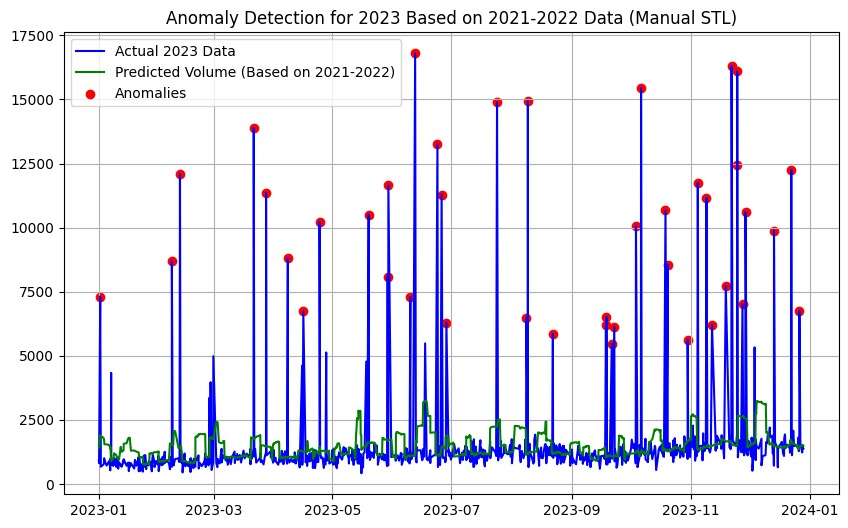

In [ ]:
# define the training and testing data. 2021, 2022 data is used for training the model.
# 2023 is the model that will be used to test and identify the anomalies.
df_combined = pd.concat([df_2021, df_2022])
df_combined['sale_date'] = pd.to_datetime(df_combined['sale_date'])
df_combined = df_combined.set_index('sale_date')

# Define period (monthly data with 12 months)
period = 12

# Calculate the Trend using a simple moving average
df_combined['trend'] = df_combined['volume_therms'].rolling(window=period, center=True).mean()

# Calculate Seasonality
# Remove the trend to get the de-trended data
df_combined['detrended'] = df_combined['volume_therms'] - df_combined['trend']

# Group by month to calculate the average seasonal component
df_combined['month'] = df_combined.index.month
seasonal_means = df_combined.groupby('month')['detrended'].mean()

# Map the seasonal means to the corresponding months
df_combined['seasonal'] = df_combined['month'].map(seasonal_means)

# Calculate the Residuals
df_combined['residuals'] = df_combined['volume_therms'] - df_combined['trend'] - df_combined['seasonal']

# Now predict the values for 2023 using the learned trend and seasonal components
df_2023['sale_date'] = pd.to_datetime(df_2023['sale_date'])
df_2023 = df_2023.set_index('sale_date')

# Predict trend and seasonality for 2023 based on the trend and seasonal means from 2021 and 2022
df_2023['trend'] = df_combined['trend'].dropna().values[-len(df_2023):]  # Using last trend values
df_2023['seasonal'] = df_2023.index.month.map(seasonal_means)

# Predicted values for 2023
df_2023['predicted_volume'] = df_2023['trend'] + df_2023['seasonal']

# Calculate residuals for 2023 and detect anomalies
df_2023['residuals'] = df_2023['volume_therms'] - df_2023['predicted_volume']

# Detect anomalies where the residuals are significantly large (e.g., z-score > 3)
z_scores = np.abs((df_2023['residuals'] - df_2023['residuals'].mean()) / df_2023['residuals'].std())
anomalies = df_2023[z_scores > 2]

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(df_2023.index, df_2023['volume_therms'], label='Actual 2023 Data', color='blue')
plt.plot(df_2023.index, df_2023['predicted_volume'], label='Predicted Volume (Based on 2021-2022)', color='green')
plt.scatter(anomalies.index, anomalies['volume_therms'], color='red', label='Anomalies')
plt.title('Anomaly Detection for 2023 Based on 2021-2022 Data (Manual STL)')
plt.legend()
plt.grid(True)
plt.show()


## 4. Anomaly Detection using STL (alternate approach using statsmodels library)

- While STL analysis was done manually using proper low-level mathematical logic, the same can also be achieved by fitting the data that we have to predefined analysis models using the standard statistics libraries available, which employs similar logic that was well explained in section 3.

- comparing the manual approach taken and the alternative approach using industrial tools, it is evident that the results are similar, and hence, the robust nature of the logic in section 3 is proven.

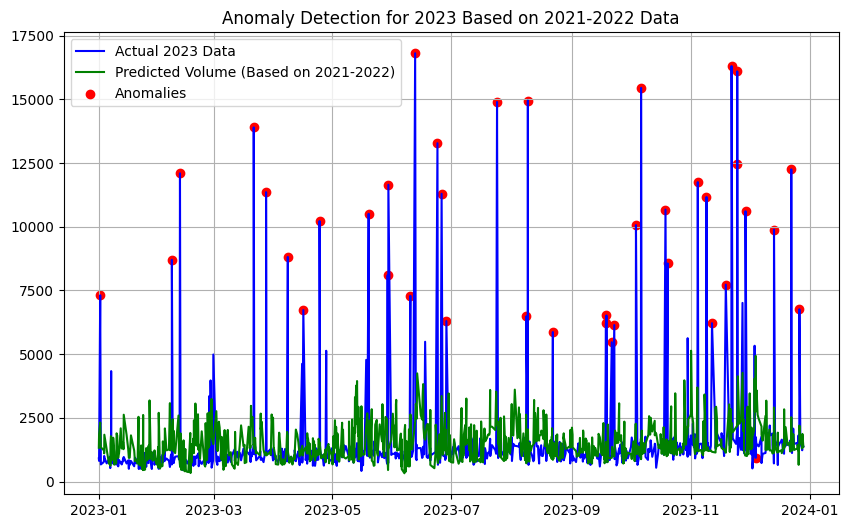

In [ ]:
from statsmodels.tsa.seasonal import STL

# Combine 2021 and 2022 data for model training
df_combined = pd.concat([df_2021, df_2022])
df_combined['sale_date'] = pd.to_datetime(df_combined['sale_date'])
df_combined = df_combined.set_index('sale_date')

# Decompose the combined data to extract the seasonal and trend components
stl = STL(df_combined['volume_therms'], seasonal=13, period=12)
result = stl.fit()

combined_trend = result.trend
combined_seasonal = result.seasonal

# Predict 2023 based on the seasonal component from the 2021 and 2022 combined data
predicted_2023_trend = combined_trend[-len(df_2023):]
predicted_2023_seasonal = combined_seasonal[-len(df_2023):]

predicted_2023 = predicted_2023_trend + predicted_2023_seasonal

# Calculate the residuals (actual - predicted)
df_2023['predicted_volume'] = predicted_2023.values
df_2023['residuals'] = df_2023['volume_therms'] - df_2023['predicted_volume']

z_scores = np.abs((df_2023['residuals'] - df_2023['residuals'].mean()) / df_2023['residuals'].std())
anomalies = df_2023[z_scores > 2]

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(df_2023.index, df_2023['volume_therms'], label='Actual 2023 Data', color='blue')
plt.plot(df_2023.index, df_2023['predicted_volume'], label='Predicted Volume (Based on 2021-2022)', color='green')
plt.scatter(anomalies.index, anomalies['volume_therms'], color='red', label='Anomalies')
plt.title('Anomaly Detection for 2023 Based on 2021-2022 Data')
plt.legend()
plt.grid(True)
plt.show()


## 5. Anomaly Detection using EWMA

- Another simple method to calculate anomalies is to use EWMA, or the **Exponentially weighted moving average method**.

- This method is **very robust against concept drifts, however, it falls short when it needs to account for seasonal trends.**

- It is more responsive to recent data compared to simple moving averages. however, the decay factor requires a lot of tuning.

- There is **no need to train the model to use past data,** it can use the recent real time data as it is updated to give the results.

- calculate the exponentially weighted moving average.
- calculate the exponentially wighted moving standard deviation.
- Detect anomalies where the actual value deviates more than the threshold * std from the EWMA. **Higher the threshold value, the less sensitive the model is. This project maintains a threshold factor of 2.**

- The ewm() function computes the exponentially weighted mean, controlled by the smoothing factor "alpha".

- **A lower alpha means more weight is given to recent data**, making the EWMA more sensitive to short-term changes. **The project uses an alpha value of 0.1.**

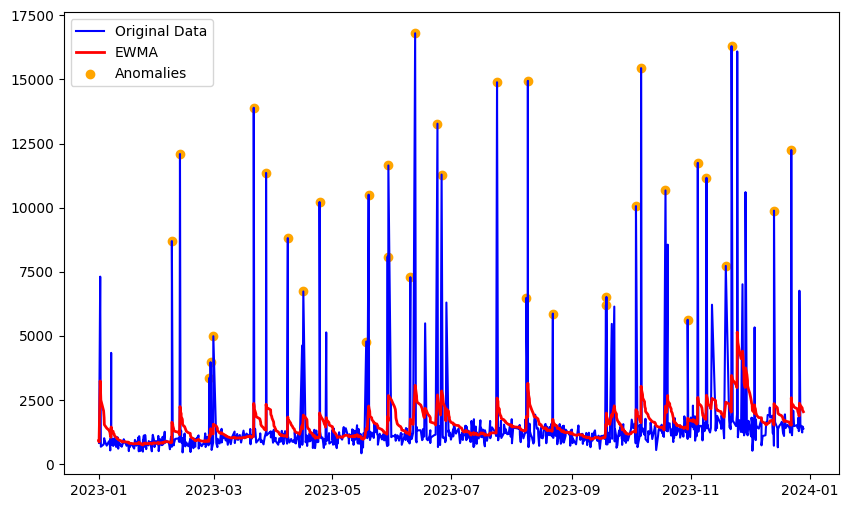

In [ ]:
# calculate the EWMA
df_2023['ewma'] = df_2023['volume_therms'].ewm(alpha=0.1).mean()
# calculate the EWM std.
df_2023['ewma_std'] = df_2023['volume_therms'].ewm(alpha=0.1).std()
# Detect anomalies using a threshold factor of 2.
df_2023['anomaly'] = (df_2023['volume_therms'] > df_2023['ewma'] + 2 * df_2023['ewma_std']) | (df_2023['volume_therms'] < df_2023['ewma'] - 2 * df_2023['ewma_std'])

# plot to visualise the anomalies.
plt.figure(figsize=(10, 6))
plt.plot(df_2023['volume_therms'], label='Original Data', color='blue')
plt.plot(df_2023['ewma'], label='EWMA', color='red', linewidth=2)
plt.scatter(df_2023[df_2023['anomaly']].index, df_2023[df_2023['anomaly']]['volume_therms'], color='orange', label='Anomalies')
plt.legend()
plt.show()

## Conclusion

Thus, a model was generated to identify the anomalies that occur with real time data. The model used data from the past two years 2021 and 2022 to get a model that can identify anomalies for sales record in 2023.

If we take a real time data from 2024 where the sales to this day is passed to this model, then we should use the data from 2022 and 2023 to train the model so that it can account for concept drifts.

Hence the model trained would realistically be updated once every year, for accuracy if we use STL (Section 3), If we use only EWMA (section 5), then the model would not need to update, as it calculates the weighted moving average using only the recent data.

While STL is clearly the better candidate for this project as it can accuratley account for Seasonal changes and accomodate concept drifts, EWMA is slightly better for concept drifts, and could also be taken into account for some rare cases as a backup.

Hence, an hybrid analysis approach is suggested for anomaly detection.